# Tutorial: Using `fastai.data` low-level APIs

> Using `DataSource`, `Pipeline`, `TfmdList`, `TfmOver`, and `Transform`

In [ ]:
from local.imports import *
from local.test import *
from local.core import *
from local.data.pipeline import *
from local.data.source import *
from local.data.core import *
from local.vision.core import *
from local.data.external import *

In [ ]:
from PIL.ImageFile import ImageFile

## Overview

In [ ]:
@patch
def dihedral(im:ImageFile, idx=0): return im.transpose(idx-1) if idx>=1 else im
def rand_dihedral(im): return im.dihedral(random.randint(0,7))

def mk_tensor(im): return tensor(array(im))[None]

- start with list of filenames
- end with iterator of tensor batches
- display a batch
- display a prediction
  - a prediction should be same structure as a batch (?)
- filename -> (image,label)
- image:
  - open
  - make tensor
  - augment (at PIL, image tensor, or batch tensor level)
    - don't apply to valid set; toggle on/off as needed (e.g. fix_dl)
    - same rand for x/y
    - segment needs nearest neighbor, bbox/points need different funcs
  - show: dataset-wide params like cmap and alpha; denorm params; to_cpu
- label:
  - view text (needs state: vocab)
  - get number
- batch:
  - concat tuples
  - normalize
  - CUDA / float tensor
  - augment

### v1

In [ ]:
source = untar_data(URLs.MNIST_TINY)/'train'
items = get_image_files(source)
fn = items[0]
img = PIL.Image.open(fn); img

In [ ]:
imgt = mk_tensor(img)
imgt.shape,type(imgt)

(torch.Size([1, 28, 28]), torch.Tensor)

In [ ]:
lbls = items.mapped(parent_label)
itos,stoi = uniqueify(lbls, bidir=True, sort=True)
lbls[0], stoi['3']

('3', 0)

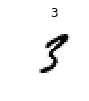

In [ ]:
show_image(imgt, title=lbls[0], figsize=(1,1), cmap="Greys");

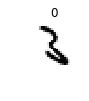

In [ ]:
pipe_open = compose(PIL.Image.open, rand_dihedral, mk_tensor)

class MNIST():
    def __getitem__(self,i): return pipe_open(items[i]), stoi[lbls[i]]
    def __len__(self): return len(items)

ds = MNIST()
show_titled_image(ds[0], figsize=(1,1), cmap="Greys")

In [ ]:
dl = DataLoader(ds, batch_size=9)
b = next(iter(dl))
x,y = to_device(b)
x = x.float()/255.

In [ ]:
def normalize  (o,m,s): return (o-m)/s
def denormalize(o,m,s): return (o*s)+m

def decode_vocab(o, v): return [v[o_] for o_ in o]

In [ ]:
m,s = 0.1,0.3
x = normalize(x,m,s)
x.mean(),x.std()

(tensor(0.0556, device='cuda:0'), tensor(0.9651, device='cuda:0'))

In [ ]:
denorm = partial(denormalize,m=m,s=s)
decode = partial(decode_vocab, v=itos)

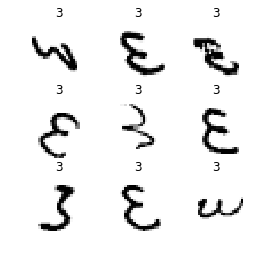

In [ ]:
show_image_batch((denorm(x),decode(y)), cmap="Greys", figsize=(4,4))

### v2

In [ ]:
vocab = SimpleNamespace(itos=itos,stoi=stoi)

In [ ]:
def floatify(o): return o.float()/255.

In [ ]:
class Normalize():
    def __init__(self, m, s): self.m,self.s = m,s
    def __call__(self,o): return (o-m)/s
    def decode  (self,o): return (o*s)+m

norm_mnist = Normalize(m,s)

In [ ]:
imgt = floatify(imgt)
imgt.mean(),imgt.std()

(tensor(0.1149), tensor(0.2901))

In [ ]:
imgn = norm_mnist(imgt)
imgn.mean(),imgn.std()

(tensor(0.0495), tensor(0.9670))

In [ ]:
imgt2 = norm_mnist.decode(imgn)
imgt2.mean(),imgt2.std()

(tensor(0.1149), tensor(0.2901))

In [ ]:
class Item():
    def __init__(self, d): self.data = d
    def __repr__(self): return str(self.obj)
    @classmethod
    def from_obj(cls, o): return cls(o)
    @property
    def obj(self): return self.data

In [ ]:
class Category(Item):
    def __init__(self, d, vocab): self.data,self.vocab = d,vocab
    @classmethod
    def from_obj(cls, o, vocab): return cls(vocab.stoi[o], vocab)
    @property
    def obj(self): return self.vocab.itos[self.data]
    def show(self, ctx=None, **kwargs): return show_title(str(self.obj), ctx=ctx, **kwargs)

In [ ]:
cat = Category(0,vocab)
cat.data,cat.obj
cat.show()

3


In [ ]:
class TensorImage(Item):
    def __init__(self, d): self.data = mk_tensor(d)
    @property
    def show(self, ctx=None, **kwargs): return show_image(to_cpu(self.obj), ctx=ctx, **kwargs)

In [ ]:
class Coder():
    def __init__(self, typ, **kwargs): self.typ,self.kw = typ,kwargs
    def __call__(self,o): return self.typ.from_obj(o, **self.kw)
    def decode(self,i): return self.typ(i, **self.kw).obj

    def show(self, i, ctx=None, fallback_show=print, **kwargs):
        i = self.typ(i, **self.kw)
        return getattr(i, 'show', fallback_show)(ctx=ctx, **kwargs)

In [ ]:
cod = Coder(Category,vocab=vocab)
cat = cod('3')
cat.data,cat.obj

(0, '3')

In [ ]:
def compose_tfms(x, tfms, func_nm='__call__', reverse=False):
    if reverse: tfms = reversed(tfms)
    for t in tfms: x = getattr(t,func_nm,noop)(x)
    return x

class Pipeline():
    def __init__(self, *tfms): self.tfms = tfms
    def __call__(self, o): return compose_tfms(o, self.tfms)
    def decode  (self, i): return compose_tfms(i, self.tfms, func_nm='decode', reverse=True)
    def show(self, b, ctx=None, **kwargs):
        for t in reversed(self.tfms):
            f = getattr(t,'show',None)
            if f: return f(b, ctx=ctx, **kwargs)

In [ ]:
pipe_open = Pipeline(PIL.Image.open, rand_dihedral, Coder(TensorImage))

In [ ]:
class MNIST():
    def __init__(self, items, lbls, f_img, f_lbl):
        self.items,self.lbls,self.f_img,self.f_lbl = items,lbls,f_img,f_lbl
    def __getitem__(self, i): return self.f_img(self.items[i]), self.f_lbl(self.lbls[i])
    def __len__(self): return len(items)

ds = MNIST(items, lbls, pipe_open, Coder(Category,vocab=vocab))

In [ ]:
class DatafyDS():
    def __init__(self,ds): self.ds=ds
    def __getitem__(self,i): return [getattr(o,'data',o) for o in self.ds[i]]
    def __len__(self): return len(self.ds)
    def decode(self, b): return self.ds.f_img.decode(b[0]),self.ds.f_lbl.decode(b[1])

In [ ]:
dds = DatafyDS(ds)
dl = DataLoader(dds, batch_size=9)

In [ ]:
class MNIST_DL():
    def __init__(self, dl, f_x, f_y): self.dl,self.f_x,self.f_y = dl,f_x,f_y
    def __iter__(self): return ((self.f_x(x),self.f_y(y)) for x,y in self.dl)
    def __len__(self): return len(self.dl)

dl_pipe_x = Pipeline(to_device, floatify, norm_mnist)
dl_pipe_y = Pipeline(to_device)
mdl = MNIST_DL(dl, dl_pipe_x, dl_pipe_y)

In [ ]:
class DatafyDL():
    def __init__(self,dl): self.dl=dl
    def __iter__(self): return ((getattr(x,'data',x), getattr(y,'data',y)) for x,y in self.dl)
    def __len__(self): return len(self.dl)

    def decode_batch(self, b):
        x,y = b
        x = self.dl.f_x.decode(x)
        y = self.dl.f_y.decode(y)
        ds = self.dl.dl.dataset
        return zip(*[ds.decode(o) for o in zip(x,y)])
    
    def show_batch(self, b, fallback_show=print, max_rows=10, ctxs=None, **kwargs):
#         fx = getattr(self.dl.f_x, 'show', None)
        fx = getattr(self.dl.dl.dataset.ds.f_img, 'show', fallback_show)
#         fy = getattr(self.dl.f_y, 'show', None)
        fy = getattr(self.dl.dl.dataset.ds.f_lbl, 'show', fallback_show)
        rows = itertools.islice(zip(*L(b)), max_rows)
        if ctxs is None: ctxs = [None] * len(b[0] if is_iter(b[0]) else b)
        for o,ctx in zip(rows,ctxs):
            ctx = fx(o[0], ctx=ctx)
            fy(o[1], ctx=ctx)

In [ ]:
ddl = DatafyDL(mdl)
x,y = next(iter(ddl))
x.mean(),x.std()

(tensor(0.0556, device='cuda:0'), tensor(0.9651, device='cuda:0'))

TypeError: can't convert CUDA tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

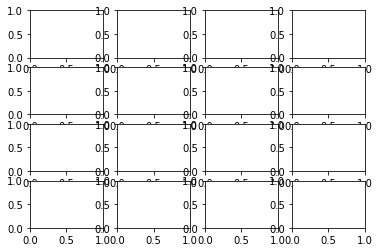

In [ ]:
fig,axs = plt.subplots(4,4)
ddl.show_batch((x,y), cmap="Greys", figsize=(4,4), ctxs=axs.flat)

### TfmOver

In [ ]:
tover = TfmOver([[timg,tconv], [parent_label,tcat]])
tover.setup()

In [ ]:
x,y = tover((fn,fn))
x.shape,y

(torch.Size([1, 28, 28]), 0)

In [ ]:
xd,yd = tover.decode((x,y))
xd.shape,yd

(torch.Size([28, 28]), '3')

In [ ]:
tover = TfmOver.piped([[timg,tconv], [parent_label,tcat]])
tover.setup()
x,y = tover(fn)  # NB: Only one input
x.shape,y

(torch.Size([1, 28, 28]), 0)

### is_tuple=True

In [ ]:
tover = TfmOver([[timg], [parent_label,tcat]])

In [ ]:
pipe = Pipeline([tover, ImageToByteTensor(is_tuple=True)])
pipe.setup()
x,y = pipe((fn,fn))
x.shape,y

(torch.Size([1, 28, 28]), 0)

In [ ]:
tover = TfmOver.piped([[timg], [parent_label,tcat]], final_tfms=ImageToByteTensor())
tover.setup()
x,y = tover(fn)
x.shape,y

(torch.Size([1, 28, 28]), 0)

## Loading the Pets dataset using only `Transform`

In [ ]:
source = untar_data(URLs.PETS)/"images"

In [ ]:
items = get_image_files(source)
split_idx = RandomSplitter()(items)

In [ ]:
def resized_image(fn, sz=128):
    x = Image.open(fn).resize((sz,sz))
    # Convert image to tensor for modeling
    return tensor(array(x)).permute(2,0,1).float()/255.

In [ ]:
class PetTfm(Transform):
    def __init__(self, items, train_idx):
        super().__init__()
        self.items,self.train_idx,self.assoc = items,train_idx,TitledImageItem()
        self.labeller = RegexLabeller(pat = r'/([^/]+)_\d+.jpg$')
        vals = map(self.labeller, items[train_idx])
        self.vocab,self.o2i = uniqueify(vals, sort=True, bidir=True)

    def encodes(self, i):
        o = self.items[i]
        return resized_image(o), self.o2i[self.labeller(o)]
    
    def decodes(self, o): return o[0],self.vocab[o[1]]

In [ ]:
pets = PetTfm(items, split_idx[0])

In [ ]:
x,y = pets[0]
x.shape,y

(torch.Size([3, 128, 128]), 21)

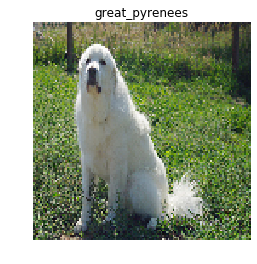

In [ ]:
pets.show((x,y))

In [ ]:
dl_tfms = [Cuda(), ByteToFloatTensor()]
trn_dl = TfmdDL(pets.train, dl_tfms, bs=9)
b = trn_dl.one_batch()

test_eq(len(b[0]), 9)
test_eq(b[0][0].shape, (3,128,128))
test_eq(b[0].type(), 'torch.cuda.FloatTensor')

In [ ]:
bd = trn_dl.decode(b)

test_eq(len(bd[0]), 9)
test_eq(bd[0][0].shape, (128,128,3))

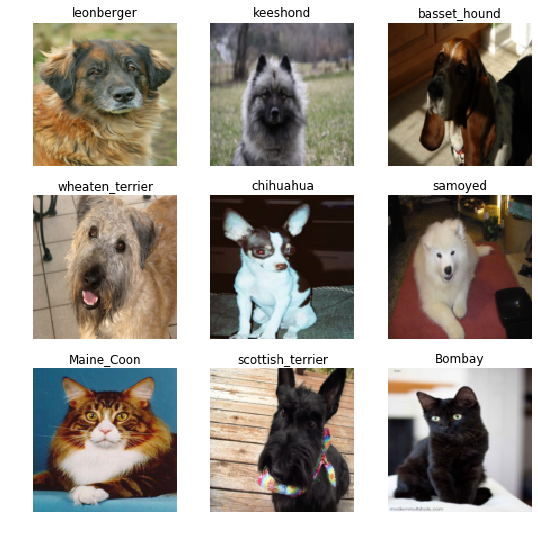

In [ ]:
_,axs = plt.subplots(3,3, figsize=(9,9))
trn_dl.show_batch(ctxs=axs.flatten())

## Using `Pipeline` to create Siamese model dataset

A *Siamese* model needs a dataset with two images as input, and a boolean output that is `True` if the two images are the "same" (e.g. are pictures of the same breed of pet). Custom structures like this are often easiest to create using `Pipeline`, which makes no assumptions about the structure of your input or output data.

In [ ]:
class SiamesePair(Transform):
    def __init__(self,items,labels):
        super().__init__()
        self.items,self.labels,self.assoc = items,labels,self
        sortlbl = sorted(enumerate(labels), key=itemgetter(1))
        # dict of (each unique label) -> (list of indices with that label)
        self.clsmap = {k:L(v).itemgot(0) for k,v in itertools.groupby(sortlbl, key=itemgetter(1))}
        self.idxs = range_of(self.items)
        
    def encodes(self,i):
        "x: tuple of `i`th image and a random image from same or different class; y: True if same class"
        othercls = self.clsmap[self.labels[i]] if random.random()>0.5 else self.idxs
        otherit = random.choice(othercls)
        x = (self.items[i], self.items[otherit])
        return x, self.labels[otherit]==self.labels[i]
    
    def show(self, o, ctx=None, **kwargs):
        (x1,x2),y = o
        show_image(torch.cat([x1,x2], dim=2), title=y, ctx=ctx)

In [ ]:
labeller = RegexLabeller(pat = r'/([^/]+)_\d+.jpg$')
sp = SiamesePair(items, items.mapped(labeller))
resized_images = Transform(mapper(resized_image), is_tuple=True)
pipe = Pipeline([sp, resized_images])
pipe.setup()

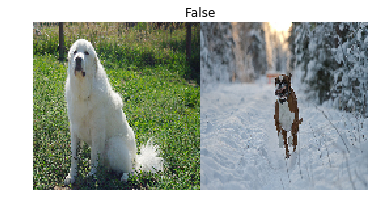

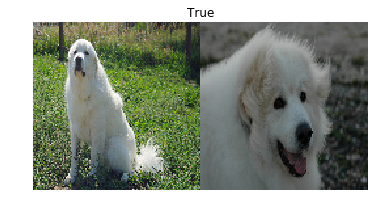

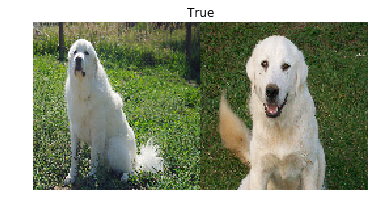

In [ ]:
for _ in range(3): pipe.show_at(0)

## Using `TfmOver`

`TfmOver` applies a list of transforms lazily to items of a collection, creating one output per transform. If passed lists of transforms, it creates `Pipeline`s of those lists. This makes it easier for us to separate out steps of a process, so that we can re-use them and modify the process more easily. For instance, we could add data augmentation, data normalization, etc. Here we separate out the steps of the basic pets process.

We use the `piped` factory method to have a single item input (in this case, a filename) replicated to create a tuple the same length as `tfms`.

In [ ]:
c = Categorize(subset_idx=split_idx[0])
tfms = [[Imagify(), ImageResizer(128), ImageToByteTensor(), ByteToFloatTensor()],
        [labeller, c]]
pl = TfmdList(items, TfmOver.piped(tfms))

In [ ]:
t = pl[0]
x,y = pl.decode(t)
x.shape,y

(torch.Size([128, 128, 3]), 'great_pyrenees')

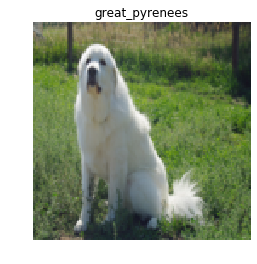

In [ ]:
pl.show(t);

## Using `DataSource`

In [ ]:
ds_img_tfms = [ImageResizer(128), ImageToByteTensor()]
tfms = [Imagify(), [labeller, Categorize()]]

Three examples of creating a DataSource, from easiest to most flexible:

1: The quick way to create a `DataSource` is with `build`:

In [ ]:
pets = DataSource.build(items, tfms, split_idx, ds_img_tfms)

2: Behind the scenes, this is using `TfmOver.piped`:

In [ ]:
tfm = TfmOver.piped(tfms, final_tfms=ds_img_tfms)
pets = DataSource(items, tfm, filts=split_idx)

3: `TfmOver.piped` creates a `Pipeline` containing a transform that replicates its input, then the `TfmOver` itself, then anything passed to `final_tfms`. All `final_tfms` are automatically marked as `is_tuple` (unless specifically marked `is_tuple=False` at creation):

In [ ]:
for t in ds_img_tfms: t.set_tupled()
tfm = Pipeline([lambda o:(o,o), TfmOver(tfms), *ds_img_tfms])
pets = DataSource(items, tfm, filts=split_idx)

To access an element we need to specify the subset (either with `train`/`valid` or with `subset(i)`):

In [ ]:
x,y = pets.subset(1)[0]
x.shape,y

(torch.Size([3, 128, 128]), 25)

...or equivalently:

In [ ]:
x2,y2 = pets.valid[0]
test_eq(x.shape,x2.shape)
test_eq(y,y2)

We can decode an element for display purposes, either passing a tuple to `decode` or by passing an index to `decode_at`.

In [ ]:
xy = pets.valid.decode((x,y))
xy[1]

'leonberger'

In [ ]:
xy2 = pets.valid.decode_at(0)
test_eq(type(xy2[1]), str)
test_eq(xy2, xy)

We're now ready to show our items.

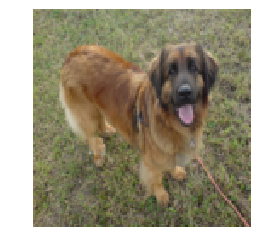

In [ ]:
pets.show((x,y));

We can use this to feed a `DataLoader` and view a batch. It's faster to convert to float on GPU, so we'll do it as a DataLoader transform, after CUDA.

In [ ]:
dl_tfms = [Cuda(), ByteToFloatTensor()]
trn_dl = TfmdDL(pets.train, dl_tfms, bs=9)
b = trn_dl.one_batch()

test_eq(len(b[0]), 9)
test_eq(b[0][0].shape, (3,128,128))
test_eq(b[0].type(), 'torch.cuda.FloatTensor')

In [ ]:
bd = trn_dl.decode(b)

test_eq(len(bd[0]), 9)
test_eq(bd[0][0].shape, (128,128,3))

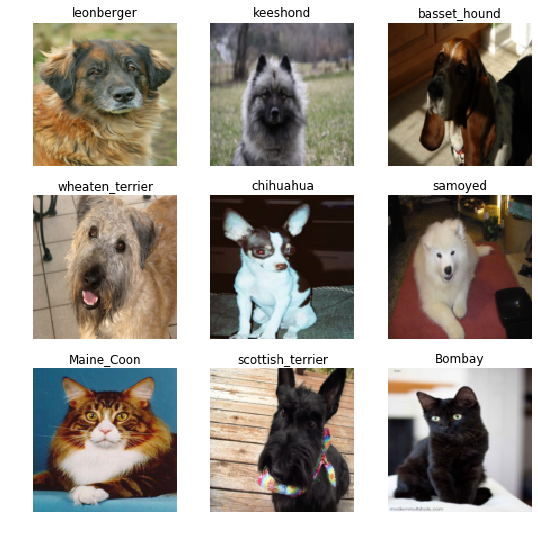

In [ ]:
_,axs = plt.subplots(3,3, figsize=(9,9))
trn_dl.show_batch(ctxs=axs.flatten())

## Segmentation

In [ ]:
cv_source = untar_data(URLs.CAMVID_TINY)
cv_items = get_image_files(cv_source/'images')
cv_splitter = RandomSplitter(seed=42)
cv_split = cv_splitter(cv_items)
cv_label = lambda o: cv_source/'labels'/f'{o.stem}_P{o.suffix}'

In [ ]:
for t in ds_img_tfms: t.mask = (True,True)
tfms = [[Imagify()],
        [cv_label, Imagify(cmap='tab20', alpha=0.5, vmin=1, vmax=30)]]
camvid = DataSource.build(cv_items, tfms, cv_split, ds_img_tfms)
trn_dl = TfmdDL(camvid.train, dl_tfms, 4)

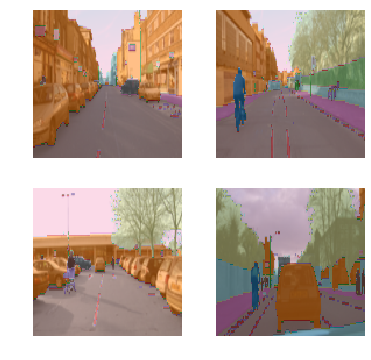

In [ ]:
_,axs = plt.subplots(2,2, figsize=(6,6))
trn_dl.show_batch(ctxs=axs.flatten())

In [ ]:
camvid.tfm.assoc

## fin -